# Импорт библиотек

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import findspark
findspark.init()

import pyspark
from pyspark.sql import SQLContext
import pyspark.sql.functions as f

from tqdm.notebook import tqdm
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

sc = pyspark.SparkContext(appName='myAppName')
sqlContext = SQLContext(sc)

# Загрузка данных

In [2]:
df = sqlContext.read.format("parquet").load("SNA/")

# выделяем целевую переменную
df = df.withColumn("liked", f.array_contains("feedback", "Liked").cast('integer'))
# Выделяем: часы и дни недели, в которые показаны посты
df = df.withColumn("hour", f.from_unixtime(f.col("audit_timestamp") / 1000, "HH").cast('integer'))
df = df.withColumn("dow", f.date_format(f.from_unixtime(f.col("audit_timestamp") / 1000), "u").cast('integer'))

print(f'shape: {df.count()}, {len(df.columns)}')

df.limit(10).toPandas()

shape: 30787847, 110


,instanceId_userId,instanceId_objectType,instanceId_objectId,audit_pos,audit_clientType,audit_timestamp,audit_timePassed,audit_resourceType,metadata_ownerId,metadata_ownerType,...,auditweights_userOwner_USER_PROFILE_VIEW,auditweights_userOwner_VIDEO,auditweights_x_ActorsRelations,auditweights_svd,ImageId,auditweights_likersSvd_hyper,date,liked,hour,dow
0,527,Post,37392482,1,API,1520155645869,11136024,8,19464,GROUP_OPEN_OFFICIAL,...,None,None,None,0.971861,[c9aa648da68a59770d457a77e7498fa8],0.404382,2018-03-04,0,12,7
1,572,Post,38438574,51,API,1520165334091,615789,8,78946,GROUP_OPEN_OFFICIAL,...,None,None,None,0.415802,"[be106efad83ec1a40d7dab92a78e2a1a, 66775fb29d3...",NaN,2018-03-04,0,15,7
2,1262,Video,511150,2,API,1520144394061,248661,6,78100,GROUP_OPEN_OFFICIAL,...,None,None,None,0.904096,None,0.895632,2018-03-04,0,9,7
3,1316,Post,34118682,1,WEB,1520181174095,16408086,8,47200,GROUP_OPEN_OFFICIAL,...,None,None,None,0.249475,[557d8dcf62bf5728ce0e60f94a94e0b9],NaN,2018-03-04,0,19,7
4,1316,Post,34093094,5,WEB,1520181319214,145227,8,47200,GROUP_OPEN_OFFICIAL,...,None,None,None,0.236818,[b90effa5e1afecdfb22d4273a57c867e],NaN,2018-03-04,0,19,7
5,1316,Photo,6307405,2,WEB,1520193058381,2667185,3,68841,GROUP_OPEN,...,None,None,None,0.116911,None,NaN,2018-03-04,0,22,7
6,1460,Post,18617580,0,WEB,1520186529845,239844,8,43523,GROUP_OPEN_OFFICIAL,...,None,None,None,0.612801,None,NaN,2018-03-04,0,21,7
7,2039,Post,30666552,30,WEB,1520170220980,8429661,8,24604,GROUP_OPEN_OFFICIAL,...,None,None,None,0.681724,[ffd7c6423b1bf84423da6080b569ae0f],0.932278,2018-03-04,0,16,7
8,2039,Post,25190325,24,WEB,1520170220980,8429661,8,80035,GROUP_OPEN_OFFICIAL,...,None,None,None,0.772499,None,NaN,2018-03-04,0,16,7
9,2039,Post,38971779,29,WEB,1520189667010,17150073,8,61560,GROUP_OPEN_OFFICIAL,...,None,None,None,0.840345,[eeda35c79b1083eed03ba5b78b59d5c5],NaN,2018-03-04,0,21,7


- instanceId_userId — идентификатор пользователя (анонимизированный);
- instanceId_objectType — тип объекта;
- instanceId_objectId — идентификатор объекта (анонимизированный);
- feedback — массив с типами реакций пользователя (наличие в массиве токена Liked говорит о том, что объект получил «класс» от пользователя);
- audit_clientType — тип платформы, с которой зашёл пользователь;
- audit_timestamp — время, когда строилась лента;
- metadata_ownerId — автор показанного объекта (анонимизированный);
- metadata_createdAt — дата создания показанного объекта.
- audit_* — расширенная информация о контексте построения ленты;
- metadata_* — расширенная информация о самом объекте;
- userOwnerCounters_* — информация о предыдущих взаимодействиях пользователя и автора контента;
- ownerUserCounters_* — информация о предыдущих взаимодействиях автора контента и пользователя;
- membership_* — информация о членстве пользователя в группе, где опубликован контент;
- user_* — подробная информация о пользователе;
- auditweights_* — большое количество runtime-признаков, извлечённых текущей системой.

In [3]:
# Кол-во уникальных значений в каждой фиче
for col in tqdm(df.columns):
    n_unique = df.agg(f.expr(f'count(distinct {col})').alias('count'))
    n_unique = n_unique.collect()[0]['count']

    d_type = df.schema[col].dataType

    print(col, '-', d_type, '-', n_unique)

# EDA

## Категориальные фичи

In [4]:
df.groupBy('instanceId_objectType').count().orderBy("count", ascending=False).show()

+---------------------+--------+
|instanceId_objectType|   count|
+---------------------+--------+
|                 Post|28601793|
|                Photo| 1411216|
|                Video|  774838|
+---------------------+--------+



In [3]:
df.groupBy('audit_clientType').count().orderBy("count", ascending=False).show()

+----------------+--------+
|audit_clientType|   count|
+----------------+--------+
|             API|13819364|
|             WEB|12885232|
|             MOB| 4083251|
+----------------+--------+



In [81]:
df.groupBy('audit_resourceType').count().orderBy("count", ascending=False).show()

+------------------+--------+
|audit_resourceType|   count|
+------------------+--------+
|                 8|26332009|
|                 3| 1411216|
|                 7| 1335147|
|                14|  934637|
|                 6|  774838|
+------------------+--------+



In [85]:
df.groupBy('metadata_ownerType').count().orderBy("count", ascending=False).show()

+-------------------+--------+
| metadata_ownerType|   count|
+-------------------+--------+
|GROUP_OPEN_OFFICIAL|26742841|
|         GROUP_OPEN| 4045006|
+-------------------+--------+



In [82]:
df.groupBy('metadata_numPolls').count().orderBy("count", ascending=False).show()

+-----------------+--------+
|metadata_numPolls|   count|
+-----------------+--------+
|                0|28499204|
|                1| 2246143|
|                2|   41634|
|                3|     562|
|                4|     196|
|                5|      48|
|               10|      16|
|               12|       9|
|               11|       9|
|                7|       7|
|               16|       6|
|                6|       5|
|                8|       4|
|                9|       2|
|               14|       2|
+-----------------+--------+



In [84]:
df.groupBy('metadata_platform').count().orderBy("count", ascending=False).show()

+-----------------+--------+
|metadata_platform|   count|
+-----------------+--------+
|            OTHER|19358156|
|              WEB| 7872480|
|          ANDROID| 2824261|
|              MOB|  429094|
|              IOS|  283943|
|         WINPHONE|   19913|
+-----------------+--------+



In [86]:
df.groupBy('membership_status').count().orderBy("count", ascending=False).show()

+-----------------+--------+
|membership_status|   count|
+-----------------+--------+
|                A|19694468|
|             null|10958920|
|                P|  106140|
|                I|    9619|
|                M|    8320|
|                Y|    7380|
|                !|    2527|
|                B|     467|
|                R|       6|
+-----------------+--------+



In [5]:
df.groupBy('user_gender').count().orderBy("count", ascending=False).show()

+-----------+--------+
|user_gender|   count|
+-----------+--------+
|          2|22751497|
|          1| 8034354|
|       null|    1986|
|          0|      10|
+-----------+--------+



In [87]:
df.groupBy('user_status').count().orderBy("count", ascending=False).show()

+-----------+--------+
|user_status|   count|
+-----------+--------+
|        128|29246267|
|        192| 1534224|
|         32|    3510|
|       null|    1986|
|         16|    1755|
|         96|      86|
|         80|      19|
+-----------+--------+



In [88]:
df.groupBy('user_is_active').count().orderBy("count", ascending=False).show()

+--------------+--------+
|user_is_active|   count|
+--------------+--------+
|             1|30780491|
|             0|    5370|
|          null|    1986|
+--------------+--------+



In [89]:
df.groupBy('user_is_deleted').count().orderBy("count", ascending=False).show()

+---------------+--------+
|user_is_deleted|   count|
+---------------+--------+
|              0|30784087|
|           null|    1986|
|              1|    1774|
+---------------+--------+



In [90]:
df.groupBy('user_is_abused').count().orderBy("count", ascending=False).show()

+--------------+--------+
|user_is_abused|   count|
+--------------+--------+
|             0|30782265|
|             1|    3596|
|          null|    1986|
+--------------+--------+



In [91]:
df.groupBy('user_is_activated').count().orderBy("count", ascending=False).show()

+-----------------+--------+
|user_is_activated|   count|
+-----------------+--------+
|                1|30785858|
|             null|    1986|
|                0|       3|
+-----------------+--------+



In [92]:
df.groupBy('user_is_semiactivated').count().orderBy("count", ascending=False).show()

+---------------------+--------+
|user_is_semiactivated|   count|
+---------------------+--------+
|                    0|28438211|
|                 null| 2325433|
|                    1|   24203|
+---------------------+--------+



## Популярность групп...

... по количеству публикаций

In [7]:
df.groupBy("metadata_ownerId").count().orderBy("count", ascending=False).show(10)

+----------------+------+
|metadata_ownerId| count|
+----------------+------+
|           37463|117830|
|           11222| 86560|
|           65305| 85199|
|           76851| 80982|
|           38703| 73092|
|           18942| 72232|
|           62833| 68176|
|           60195| 67020|
|           11163| 66018|
|           67111| 65434|
+----------------+------+
only showing top 10 rows



... по количеству членов группы

In [9]:
df.filter(df["membership_status"].isNotNull()).groupBy("metadata_ownerId").count().orderBy("count", ascending=False).show(10)

+----------------+-----+
|metadata_ownerId|count|
+----------------+-----+
|           76851|71193|
|           65305|56387|
|           38703|51029|
|           60195|49951|
|           67111|48724|
|           37463|47367|
|           10644|44296|
|           30830|42305|
|           11222|41663|
|           66769|40229|
+----------------+-----+
only showing top 10 rows



... по количеству лайков

In [10]:
df.filter("liked == 1").groupBy("metadata_ownerId").count().orderBy("count", ascending=False).show(10)

+----------------+-----+
|metadata_ownerId|count|
+----------------+-----+
|           37463|32472|
|           11222|22994|
|           62833|18689|
|           18942|17532|
|           11163|16327|
|           60195|15947|
|           23051|15393|
|           17215|15155|
|           65305|15150|
|           79619|14474|
+----------------+-----+
only showing top 10 rows



## Графики

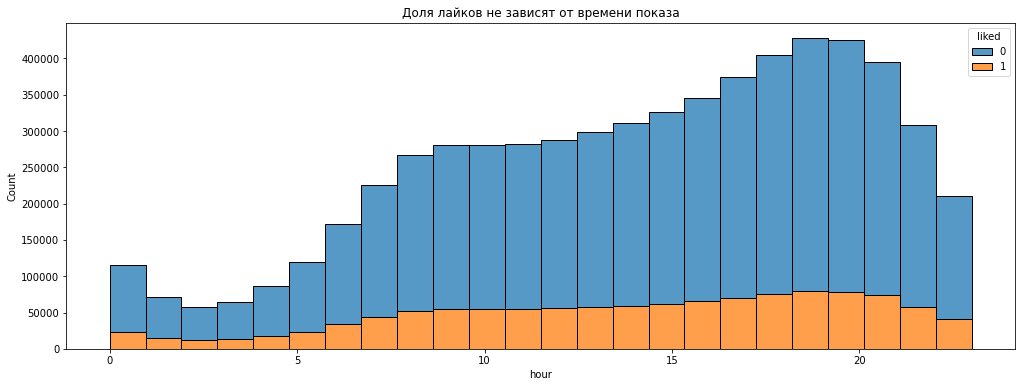

In [15]:
df1 = df.select("hour","liked").sampleBy("liked", fractions={0: 0.2, 1: 0.2}, seed=0).toPandas()

plt.figure(figsize=(17,6))
sns.histplot(df1, x="hour", hue="liked", multiple="stack", bins=24);
plt.title('Доля лайков не зависят от времени показа');

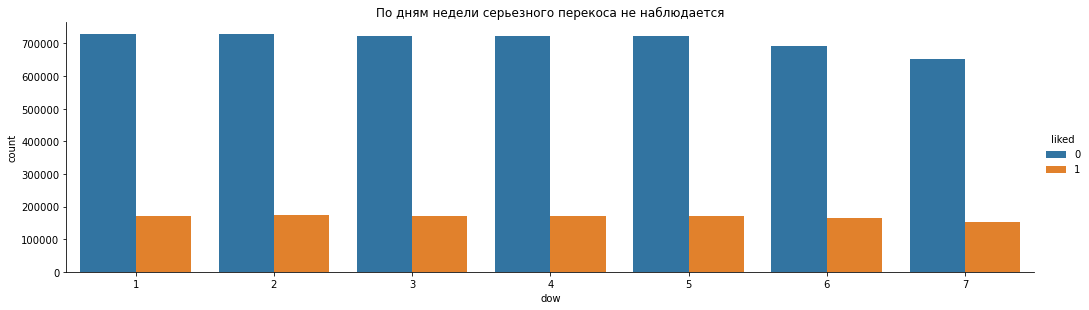

In [16]:
df1 = df.select("dow","liked").sampleBy("liked", fractions={0: 0.2, 1: 0.2}, seed=0).toPandas()

sns.catplot(data=df1, x="dow", kind="count", hue="liked", height=4, aspect=3.6)
plt.title('По дням недели серьезного перекоса не наблюдается');

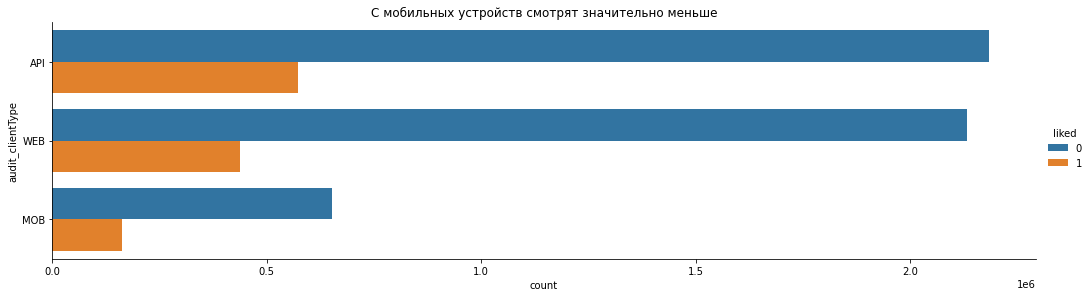

In [17]:
df1 = df.select("audit_clientType","liked").sampleBy("liked", fractions={0: 0.2, 1: 0.2}, seed=0).toPandas()

sns.catplot(data=df1, y="audit_clientType", kind="count", hue="liked", height=4, aspect=3.6, orient='h')
plt.title('С мобильных устройств смотрят значительно меньше');

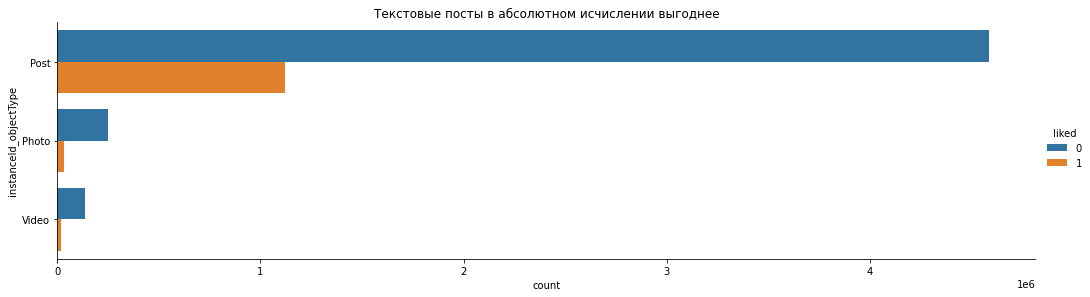

In [18]:
df1 = df.select("instanceId_objectType","liked").sampleBy("liked", fractions={0: 0.2, 1: 0.2}, seed=0).toPandas()

sns.catplot(data=df1, y="instanceId_objectType", kind="count", hue="liked", height=4, aspect=3.6, orient='h')
plt.title('Текстовые посты в абсолютном исчислении выгоднее');

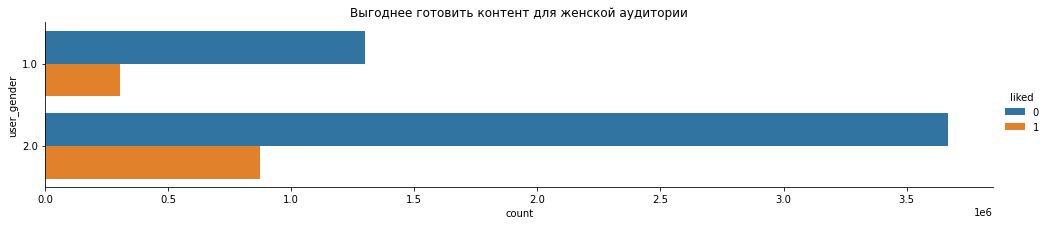

In [19]:
df1 = df.select("user_gender","liked").sampleBy("liked", fractions={0: 0.2, 1: 0.2}, seed=0).toPandas()

sns.catplot(data=df1, y="user_gender", kind="count", hue="liked", height=3, aspect=4.6, orient='h')
plt.title('Выгоднее готовить контент для женской аудитории');

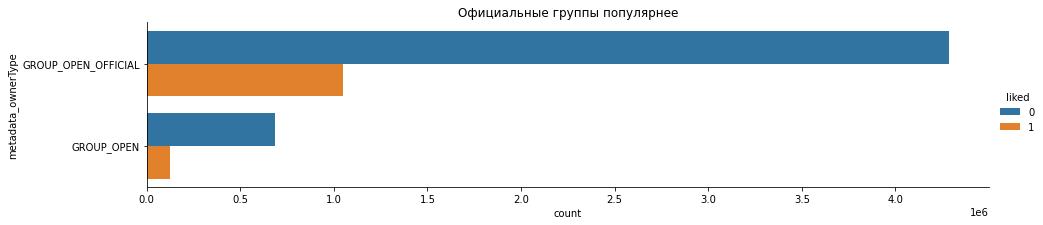

In [20]:
df1 = df.select("metadata_ownerType","liked").sampleBy("liked", fractions={0: 0.2, 1: 0.2}, seed=0).toPandas()

sns.catplot(data=df1, y="metadata_ownerType", kind="count", hue="liked", height=3, aspect=4.6, orient='h')
plt.title('Официальные группы популярнее');

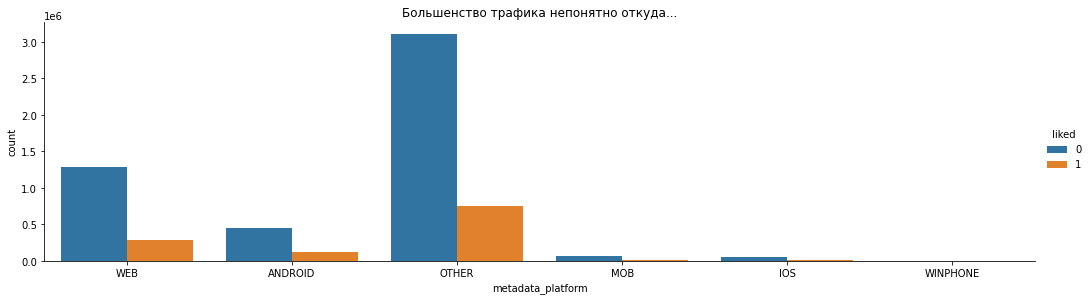

In [33]:
df1 = df.select("metadata_platform","liked").sampleBy("liked", fractions={0: 0.2, 1: 0.2}, seed=0).toPandas()

sns.catplot(data=df1, x="metadata_platform", kind="count", hue="liked", height=4, aspect=3.6)
plt.title('Большенство трафика непонятно откуда...');

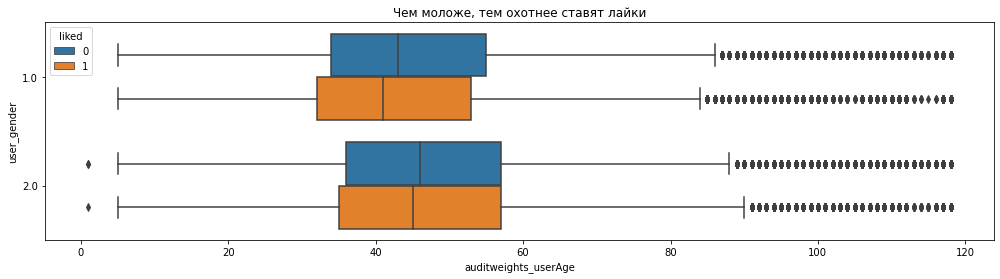

In [32]:
df1 = df.select("user_gender","auditweights_userAge","liked").sampleBy(
    "liked", fractions={0: 0.2, 1: 0.2}, seed=0).toPandas()

plt.figure(figsize=(17,4))
sns.boxplot(y="user_gender", x="auditweights_userAge", hue="liked", data=df1, orient='h')
plt.title('Чем моложе, тем охотнее ставят лайки');

# Корреляция

In [12]:
cols = [
    'audit_pos',
    'audit_timePassed',
    'metadata_numCompanions',
    'metadata_numPhotos',
    'metadata_numSymbols',
    'metadata_numTokens',
    'metadata_totalVideoLength',
    'userOwnerCounters_USER_FEED_REMOVE',
    'userOwnerCounters_UNKNOWN',
    'userOwnerCounters_CREATE_TOPIC',
    'userOwnerCounters_CREATE_IMAGE',
    'userOwnerCounters_CREATE_MOVIE',
    'userOwnerCounters_CREATE_COMMENT',
    'userOwnerCounters_CREATE_LIKE',
    'userOwnerCounters_IMAGE',
    'userOwnerCounters_VIDEO',
    'auditweights_ageMs',
    'auditweights_ctr_gender',
    'auditweights_ctr_high',
    'auditweights_ctr_negative',
    'auditweights_dailyRecency',
    'auditweights_feedOwner_RECOMMENDED_GROUP',
    'auditweights_feedStats',
    'auditweights_likersFeedStats_hyper',
    'auditweights_numDislikes',
    'auditweights_numLikes',
    'auditweights_numShows',
    'auditweights_userAge',
    'auditweights_userOwner_CREATE_COMMENT',
    'auditweights_userOwner_CREATE_IMAGE',
    'auditweights_userOwner_CREATE_LIKE',
    'auditweights_userOwner_IMAGE',
    'auditweights_userOwner_PHOTO_VIEW',
    'auditweights_userOwner_TEXT',
    'auditweights_userOwner_UNKNOWN',
    'auditweights_userOwner_USER_FEED_REMOVE',
    'auditweights_userOwner_VIDEO',
    'auditweights_x_ActorsRelations',
    'auditweights_svd',
    'auditweights_likersSvd_hyper',
    'hour']

for col in cols:
    corr = df.stat.corr(col, "liked")
    print(f'{col}:', round(corr,5))

audit_pos: 0.01345
audit_timePassed: 0.01074
metadata_numCompanions: -0.00408
metadata_numPhotos: 0.00066
metadata_numSymbols: -0.03827
metadata_numTokens: -0.03828
metadata_totalVideoLength: -0.0101
userOwnerCounters_USER_FEED_REMOVE: -0.03753
userOwnerCounters_UNKNOWN: 0.0006
userOwnerCounters_CREATE_TOPIC: 0.00136
userOwnerCounters_CREATE_IMAGE: 0.00021
userOwnerCounters_CREATE_MOVIE: 0.00037
userOwnerCounters_CREATE_COMMENT: -0.00036
userOwnerCounters_CREATE_LIKE: 0.08363
userOwnerCounters_IMAGE: -0.00627
userOwnerCounters_VIDEO: -0.00356
auditweights_ageMs: 0.02956
auditweights_ctr_gender: 0.00482
auditweights_ctr_high: 0.14511
auditweights_ctr_negative: 3e-05
auditweights_dailyRecency: -0.02917
auditweights_feedOwner_RECOMMENDED_GROUP: -0.04568
auditweights_feedStats: 0.05907
auditweights_likersFeedStats_hyper: 0.03311
auditweights_numDislikes: 0.01205
auditweights_numLikes: 0.02165
auditweights_numShows: -0.00014
auditweights_userAge: -0.02461
auditweights_userOwner_CREATE_COMME